In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib notebook

data_dir = '../../data/pain_no_pain_x2h_intervals_for_extraction_672_380_0.2fps/aslan/20190103122542_130850/'
im_file = os.path.join(data_dir, '0/as_00_0_000059.jpg')
det_file = os.path.join(data_dir, '0_dets/as_00_0_000059.npz')

desired_size = 128
buffer_size = 0.1
org_im_width = 672
org_im_height = 380
    
    

loaded_data = np.load(det_file)
pred_classes = loaded_data['pred_classes']
scores = loaded_data['scores']
pred_boxes = loaded_data['pred_boxes']

print (scores,pred_classes, pred_boxes)

idx_sort = np.argsort(scores)[::-1]
pred_classes = pred_classes[idx_sort]
scores = scores[idx_sort]
pred_boxes = pred_boxes[idx_sort,:]

print (scores,pred_classes, pred_boxes)

# return
idx_horse = np.where(pred_classes==17)[0][0]
pred_box = pred_boxes[idx_horse,:]
print (pred_box)
# pred_box[2] = pred_box[2]- pred_box[0]
# pred_box[0] = 0
# pred_box[3] = pred_box[3]- pred_box[1]
# pred_box[1] = 0


im = cv2.imread(im_file)
im = cv2.rectangle(im,(int(pred_box[0]),int(pred_box[1])),(int(pred_box[2]),int(pred_box[3])),(0,0,255))
plt.figure()
plt.imshow(im[:,:,::-1])

In [ ]:

# make pred_box square
box_size = np.array([pred_box[2]-pred_box[0],pred_box[3]-pred_box[1]])
print (box_size)
if box_size[0]<box_size[1]:
    diff = (box_size[1]-box_size[0])/2
    to_add = np.array([-diff,0,+diff,0])
else:
    diff = (box_size[0]-box_size[1])/2
    to_add = np.array([0,-diff,0,+diff])
pred_box = pred_box+to_add
print ('squared',pred_box)
pred_box = pred_box.astype(int)

im = cv2.rectangle(im,(int(pred_box[0]),int(pred_box[1])),(int(pred_box[2]),int(pred_box[3])),(0,0,255))
plt.figure()
plt.imshow(im[:,:,::-1])

In [ ]:
# expand with buffer
to_expand = buffer_size*box_size
to_expand = np.array([-to_expand[0],-to_expand[1],+to_expand[0],+to_expand[1]]).astype(int)
print ('to_expand',to_expand)
pred_box = pred_box+to_expand
print ('pred_box',pred_box)

im = cv2.rectangle(im,(int(pred_box[0]),int(pred_box[1])),(int(pred_box[2]),int(pred_box[3])),(0,0,255))
plt.figure()
plt.imshow(im[:,:,::-1])


im_curr = np.array(im)
pred_box_org = np.array(pred_box)

In [ ]:

pred_box = np.array(pred_box_org)
# pad image to complete expansion
left = -1*min(pred_box[0],0)
top =  -1*min(pred_box[1],0)
right = max(0,pred_box[2]-(org_im_width-1))
bottom = max(0,pred_box[3]-(org_im_height-1))
print (top,left,bottom,right)

im = cv2.copyMakeBorder(np.array(im_curr), top, bottom, left, right, cv2.BORDER_REPLICATE)
im_size = (im.shape[1],im.shape[0])
print ('im_size',im_size)

# shift pred_box for padded image
pred_box = pred_box+np.array([left,top,left,top])
print (pred_box)

# double check box in im
print ('before',pred_box)
pred_box[0] = max(0,pred_box[0])
pred_box[1] = max(0,pred_box[1])
pred_box[2] = min(im_size[0]-1,pred_box[2])
pred_box[3] = min(im_size[1]-1,pred_box[3])
print ('after',pred_box)

im = cv2.rectangle(im,(int(pred_box[0]),int(pred_box[1])),(int(pred_box[2]),int(pred_box[3])),(0,255,255))
plt.figure()
plt.imshow(im[:,:,::-1])


In [ ]:
import PIL
from PIL import Image
# crop im
im_crop = im[pred_box[1]:pred_box[3],pred_box[0]:pred_box[2]]
plt.figure()
plt.imshow(im_crop[:,:,::-1])

# resize crop im
im_final = cv2.resize(im_crop, (desired_size,desired_size),interpolation = cv2.INTER_CUBIC)
assert im_final.shape[0] == desired_size
assert im_final.shape[1] == desired_size

plt.figure()
plt.imshow(im_final[:,:,::-1])

im_final = Image.fromarray(im_crop[:,:,::-1]).resize((desired_size,desired_size), resample=PIL.Image.BICUBIC)
plt.figure()
plt.imshow(im_final)

<IPython.core.display.Javascript object>


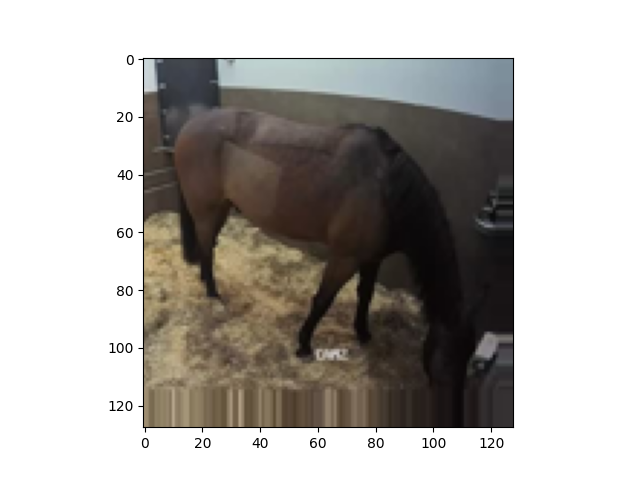

<IPython.core.display.Javascript object>


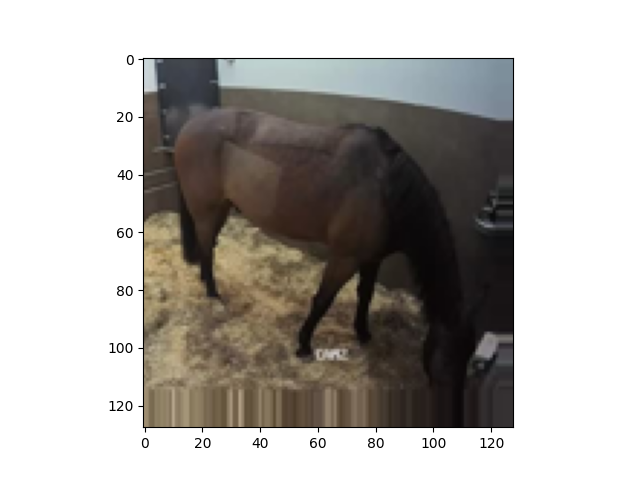

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib notebook
import PIL
from PIL import Image

def save_crop_and_det(im_file, det_file, desired_size, buffer_size, out_im_file, out_crop_info_file):
    loaded_data = np.load(det_file)
    pred_classes = loaded_data['pred_classes']
    scores = loaded_data['scores']
    pred_boxes = loaded_data['pred_boxes']
    
    if len(pred_classes)==0 or (17 not in pred_classes):
        return 0
    
    im = cv2.imread(im_file)
    org_im_width = im.shape[1]
    org_im_height = im.shape[0]
    
    # pick the best horse
    idx_sort = np.argsort(scores)[::-1]
    pred_classes = pred_classes[idx_sort]
    scores = scores[idx_sort]
    pred_boxes = pred_boxes[idx_sort,:]
    idx_horse = np.where(pred_classes==17)[0][0]
    pred_box = pred_boxes[idx_horse,:]
    
#     im = cv2.rectangle(im,(int(pred_box[0]),int(pred_box[1])),(int(pred_box[2]),int(pred_box[3])),(0,255,255))
#     plt.figure()
#     plt.imshow(im[:,:,::-1])
    
    # make pred_box square
    box_size = np.array([pred_box[2]-pred_box[0],pred_box[3]-pred_box[1]])
    if box_size[0]<box_size[1]:
        diff = (box_size[1]-box_size[0])/2
        to_add = np.array([-diff,0,+diff,0])
    else:
        diff = (box_size[0]-box_size[1])/2
        to_add = np.array([0,-diff,0,+diff])
    pred_box = pred_box+to_add
    pred_box = pred_box.astype(int)
    
    # expand with buffer
    to_expand = buffer_size*box_size
    to_expand = np.array([-to_expand[0],-to_expand[1],+to_expand[0],+to_expand[1]]).astype(int)
    pred_box = pred_box+to_expand
    
    # pad image to complete expansion
    left = -1*min(pred_box[0],0)
    top =  -1*min(pred_box[1],0)
    right = max(0,pred_box[2]-(org_im_width-1))
    bottom = max(0,pred_box[3]-(org_im_height-1))
    to_pad = np.array([top,bottom,left,right])

    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_REPLICATE)
    im_size = (im.shape[1],im.shape[0])

    # shift pred_box for padded image
    pred_box = pred_box+np.array([left,top,left,top])

    # double check box in im
    pred_box[0] = max(0,pred_box[0])
    pred_box[1] = max(0,pred_box[1])
    pred_box[2] = min(im_size[0]-1,pred_box[2])
    pred_box[3] = min(im_size[1]-1,pred_box[3])
    
    # crop im
    im_crop = im[pred_box[1]:pred_box[3],pred_box[0]:pred_box[2]]
    
    # resize crop. switch to PIL for better resize
    im_final = Image.fromarray(im_crop[:,:,::-1]).resize((desired_size,desired_size), resample=PIL.Image.BICUBIC)
    

    return im_final, to_pad, pred_box
    
def main():
    data_dir = '../../data/pain_no_pain_x2h_intervals_for_extraction_672_380_0.2fps/aslan/20190103122542_130850/'
    im_file = os.path.join(data_dir, '0/as_00_0_000104.jpg')
    det_file = os.path.join(data_dir, '0_dets/as_00_0_000104.npz')

    desired_size = 128
    buffer_size = 0.1
    org_im_width = 672
    org_im_height = 380

    im_final, to_pad, pred_box = save_crop_and_det(im_file, det_file, desired_size, buffer_size, None, None)
   
    plt.figure()
    plt.imshow(im_final)

    im = cv2.imread(im_file)
    im = cv2.copyMakeBorder(im, to_pad[0], to_pad[1], to_pad[2], to_pad[3], cv2.BORDER_REPLICATE)
    im = im[pred_box[1]:pred_box[3],pred_box[0]:pred_box[2],:]

    im_final = Image.fromarray(im[:,:,::-1]).resize((desired_size,desired_size), resample=PIL.Image.BICUBIC)
    

    plt.figure()
    plt.imshow(im_final)

main()